In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import sys

import seaborn as sns

In [2]:
root_dir = os.path.dirname(os.getcwd())

# Directorios principales
ProcesamientoDatos_dir = os.path.join(root_dir, 'a. Procesamiento de datos')
Estudios_dir = os.path.join(root_dir, 'b. Estudio Correlacion y Sistema')
Simulacion_dir = os.path.join(root_dir, 'c. Simulacion sistema')

# Datos de entrada
Datos_dir = os.path.join(os.path.dirname(root_dir), '1. Datos de entrada')
GenData_dir = os.path.join(Datos_dir, 'Generacion')
datosCEN_dir = os.path.join(GenData_dir, 'Datos_CEN')

# Directorios de procesamiento de datos
Figures_dir = os.path.join(ProcesamientoDatos_dir, 'Figures')
Output_dir = os.path.join(ProcesamientoDatos_dir, 'Output')

#Crear las carpetas que no existan
if not os.path.exists(Figures_dir): os.makedirs(Figures_dir)
if not os.path.exists(Output_dir): os.makedirs(Output_dir)

# Directorios de coordenadas de centrales generado por el script 1.-GenerarCoordenadasCentrales.ipynb
coord_dir = os.path.join(Output_dir, 'Coordenadas_CEN.xlsx')
df_coord = pd.read_excel(coord_dir)

In [3]:
def cargar_dataset(Data_dir):
    df_sol_data = pd.read_parquet(os.path.join(Data_dir, 'df_sol_data.parquet'))
    df_eol_data = pd.read_parquet(os.path.join(Data_dir, 'df_eol_data.parquet'))
    df_hid_data = pd.read_parquet(os.path.join(Data_dir, 'df_hid_data.parquet'))

    df_PotenciaSistema = pd.read_parquet(os.path.join(Data_dir, 'df_PotenciaSistema.parquet'))

    df_sol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Solar')
    df_eol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Eolica')
    df_hid_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Hidro')

    df_tech_data = [df_sol_data, df_eol_data, df_hid_data]
    df_tech_info = [df_sol_info, df_eol_info, df_hid_info]

    return df_tech_data, df_tech_info, df_PotenciaSistema

[df_sol_data, df_eol_data, df_hid_data], [df_sol_info, df_eol_info, df_hid_info], df_PotenciaSistema = cargar_dataset(Output_dir)

In [4]:
def GraficarCentrales_Tech_mean(df_tech_data,df_tech_info,tech,save_folder, color='blue'):

    Palabras_EnRevision = ["[EN_REVISION]","[En_Revision]","[NO_MOSTRAR]","[No_Mostrar]"]

    for central in df_tech_data.columns[4:]:
    #print(f'Graficando central hidroeléctrica {central}')
        if central not in df_tech_info['Nombre'].values:
            if any(palabra in central for palabra in Palabras_EnRevision):
                continue
            print(f'Central {central} | Max_Gen: {df_tech_data[central].max()} MW | No se encuentra en la base de datos de {tech}')
            Pot_inst = df_tech_data[central].max()
            pot_aprox = True
        else:
            Pot_inst = df_tech_info[df_tech_info['Nombre']==central]['PotenciaMax'].values[0]
            pot_aprox = False

        fig, ax = plt.subplots(figsize=(12,6))
        #sns.lineplot(data=df_hid_data,x='Year',y=central,ax=ax)
        df_plot = df_tech_data.loc[:,['Year','Month','Day','Hour',central]].groupby(['Year','Month','Hour']).mean().reset_index().drop(columns=['Day'])
        #print(df_plot)
        ax.plot(df_plot[central],label=central, color=color)
        if pot_aprox:
            ax.axhline(y=Pot_inst, color='r', linestyle='--',label=f'Potencia: {Pot_inst} MW')
        else:
            ax.axhline(y=Pot_inst, color='k', linestyle='--',label=f'Potencia: {Pot_inst} MW')
        # Agregar los años en x labels, cada año tiene 8760 horas
        ax.set_xticks(np.arange(0,len(df_hid_data)/30,8760/30))
        ax.set_xticklabels(df_hid_data['Year'].unique())

        ax.set_title(f'Despacho de la central {central}')
        ax.set_xlabel('Año')
        ax.set_ylabel('Potencia [MW]')
        # Leyenda abajo del gráfico
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.175), shadow=True, ncol=2)
        plt.tight_layout()
        plt.savefig(os.path.join(save_folder,f'{central}.png'))
        plt.close()

Hidro_dir = os.path.join(Figures_dir, 'Hidro_mean')
if not os.path.exists(Hidro_dir): os.makedirs(Hidro_dir)
GraficarCentrales_Tech_mean(df_hid_data,df_hid_info,'Hidro',Hidro_dir)

Eolica_dir = os.path.join(Figures_dir, 'Eolica_mean')
if not os.path.exists(Eolica_dir): os.makedirs(Eolica_dir)
GraficarCentrales_Tech_mean(df_eol_data,df_eol_info,'Eolica',Eolica_dir, color='green')

Solar_dir = os.path.join(Figures_dir, 'Solar_mean')
if not os.path.exists(Solar_dir): os.makedirs(Solar_dir)
GraficarCentrales_Tech_mean(df_sol_data,df_sol_info,'Solar',Solar_dir, color='orange')

In [5]:
def GraficarCentrales_Tech(df_tech_data,df_tech_info,tech,save_folder, color='blue'):

    Palabras_EnRevision = ["[EN_REVISION]","[En_Revision]","[NO_MOSTRAR]","[No_Mostrar]"]

    for central in df_tech_data.columns[4:]:
    #print(f'Graficando central hidroeléctrica {central}')
        if central not in df_tech_info['Nombre'].values:
            if any(palabra in central for palabra in Palabras_EnRevision):
                continue
            print(f'Central {central} | Max_Gen: {df_tech_data[central].max()} MW | No se encuentra en la base de datos de {tech}')
            Pot_inst = df_tech_data[central].max()
            pot_aprox = True
        else:
            Pot_inst = df_tech_info[df_tech_info['Nombre']==central]['PotenciaMax'].values[0]
            pot_aprox = False

        fig, ax = plt.subplots(figsize=(12,6))
        #sns.lineplot(data=df_hid_data,x='Year',y=central,ax=ax)
        ax.plot(df_tech_data[central],label=central, color=color)
        if pot_aprox:
            ax.axhline(y=Pot_inst, color='r', linestyle='--',label=f'Potencia: {Pot_inst} MW')
        else:
            ax.axhline(y=Pot_inst, color='k', linestyle='--',label=f'Potencia: {Pot_inst} MW')
        # Agregar los años en x labels, cada año tiene 8760 horas
        ax.set_xticks(np.arange(0,len(df_hid_data),8760))
        ax.set_xticklabels(df_hid_data['Year'].unique())

        ax.set_title(f'Despacho de la central {central}')
        ax.set_xlabel('Año')
        ax.set_ylabel('Potencia [MW]')
        # Leyenda abajo del gráfico
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.175), shadow=True, ncol=2)
        plt.tight_layout()
        plt.savefig(os.path.join(save_folder,f'{central}.png'))
        plt.close()

Hidro_dir = os.path.join(Figures_dir, 'Hidro')
if not os.path.exists(Hidro_dir): os.makedirs(Hidro_dir)
GraficarCentrales_Tech(df_hid_data,df_hid_info,'Hidro',Hidro_dir, color='blue')

Solar_dir = os.path.join(Figures_dir, 'Solar')
if not os.path.exists(Solar_dir): os.makedirs(Solar_dir)
GraficarCentrales_Tech(df_sol_data,df_sol_info,'Solar',Solar_dir, color='orange')

Eolico_dir = os.path.join(Figures_dir, 'Eolico')
if not os.path.exists(Eolico_dir): os.makedirs(Eolico_dir)
GraficarCentrales_Tech(df_eol_data,df_eol_info,'Eolico',Eolico_dir, color='green')

Gráficar Generación Sistémica

In [6]:
def Calcular_GenSist(df_data,df_info,tech):
    Palabras_EnRevision = ["[EN_REVISION]","[En_Revision]","[NO_MOSTRAR]","[No_Mostrar]"]

    dfs_Sumar = []
    Pot_Sist = 0

    df_Time = df_data[['Year','Month','Day','Hour']]

    for central in df_data.columns[4:]:
    #print(f'Graficando central hidroeléctrica {central}')
        if central not in df_info['Nombre'].values:
            if any(palabra in central for palabra in Palabras_EnRevision):
                continue
            print(f'Central {central} | Max_Gen: {df_data[central].max()} MW | No se encuentra en la base de datos')
            Pot_inst = df_data[central].max()
        else:
            Pot_inst = df_info[df_info['Nombre']==central]['PotenciaMax'].values[0]

        dfs_Sumar.append(df_data[central])
        Pot_Sist += Pot_inst

    df_Sist = pd.concat(dfs_Sumar,axis=1)
    df_Sist = pd.concat([df_Time,df_Sist],axis=1)
    df_Sist.set_index(['Year','Month','Day','Hour'],inplace=True)

    df_Sist = df_Sist.sum(axis=1).to_frame(name=tech)
    return df_Sist, Pot_Sist

df_Sist_Hid, Pot_Sist_Hid = Calcular_GenSist(df_hid_data,df_hid_info,'Hidro')
df_Sist_Sol, Pot_Sist_Sol = Calcular_GenSist(df_sol_data,df_sol_info,'Solar')
df_Sist_Eol, Pot_Sist_Eol = Calcular_GenSist(df_eol_data,df_eol_info,'Eolico')

df_Sist = pd.concat([df_Sist_Hid,df_Sist_Sol,df_Sist_Eol],axis=1)

In [7]:
df_Sist['Hidro']

Year  Month  Day  Hour
2020  1      1    0       1257.528440
                  1       1253.959777
                  2       1204.398522
                  3       1161.605529
                  4       1149.202003
                             ...     
2024  6      30   19      1367.670131
                  20      1386.709380
                  21      1439.589361
                  22      1446.438566
                  23      1433.734254
Name: Hidro, Length: 39384, dtype: float64

In [8]:
# Parametros de entrada (deben ser modificados dependiendo de los años a analizar)
years = [2020,2021,2022,2023,2024]  # Vector con los años a analizar
last_year_month = 3  # Mes del último año a analizar, si se tiene el año completo utilizar 12

# Parametros fijos
last_day = {'01':31,'02':28,'03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}
Años_bisiestos = [2020,2024,2028,2032,2036,2040,2044,2048,2052,2056,2060]  # Años bisiestos
meses = ['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre','diciembre']  # Vector con los meses del año
months_numbers = {'enero':'01','febrero':'02','marzo':'03','abril':'04','mayo':'05','junio':'06','julio':'07','agosto':'08','septiembre':'09','octubre':'10','noviembre':'11','diciembre':'12'}  # Diccionario que relaciona el nombre del mes con su número
numbers_months = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}  # Diccionario que relaciona el número del mes con su nombre

3


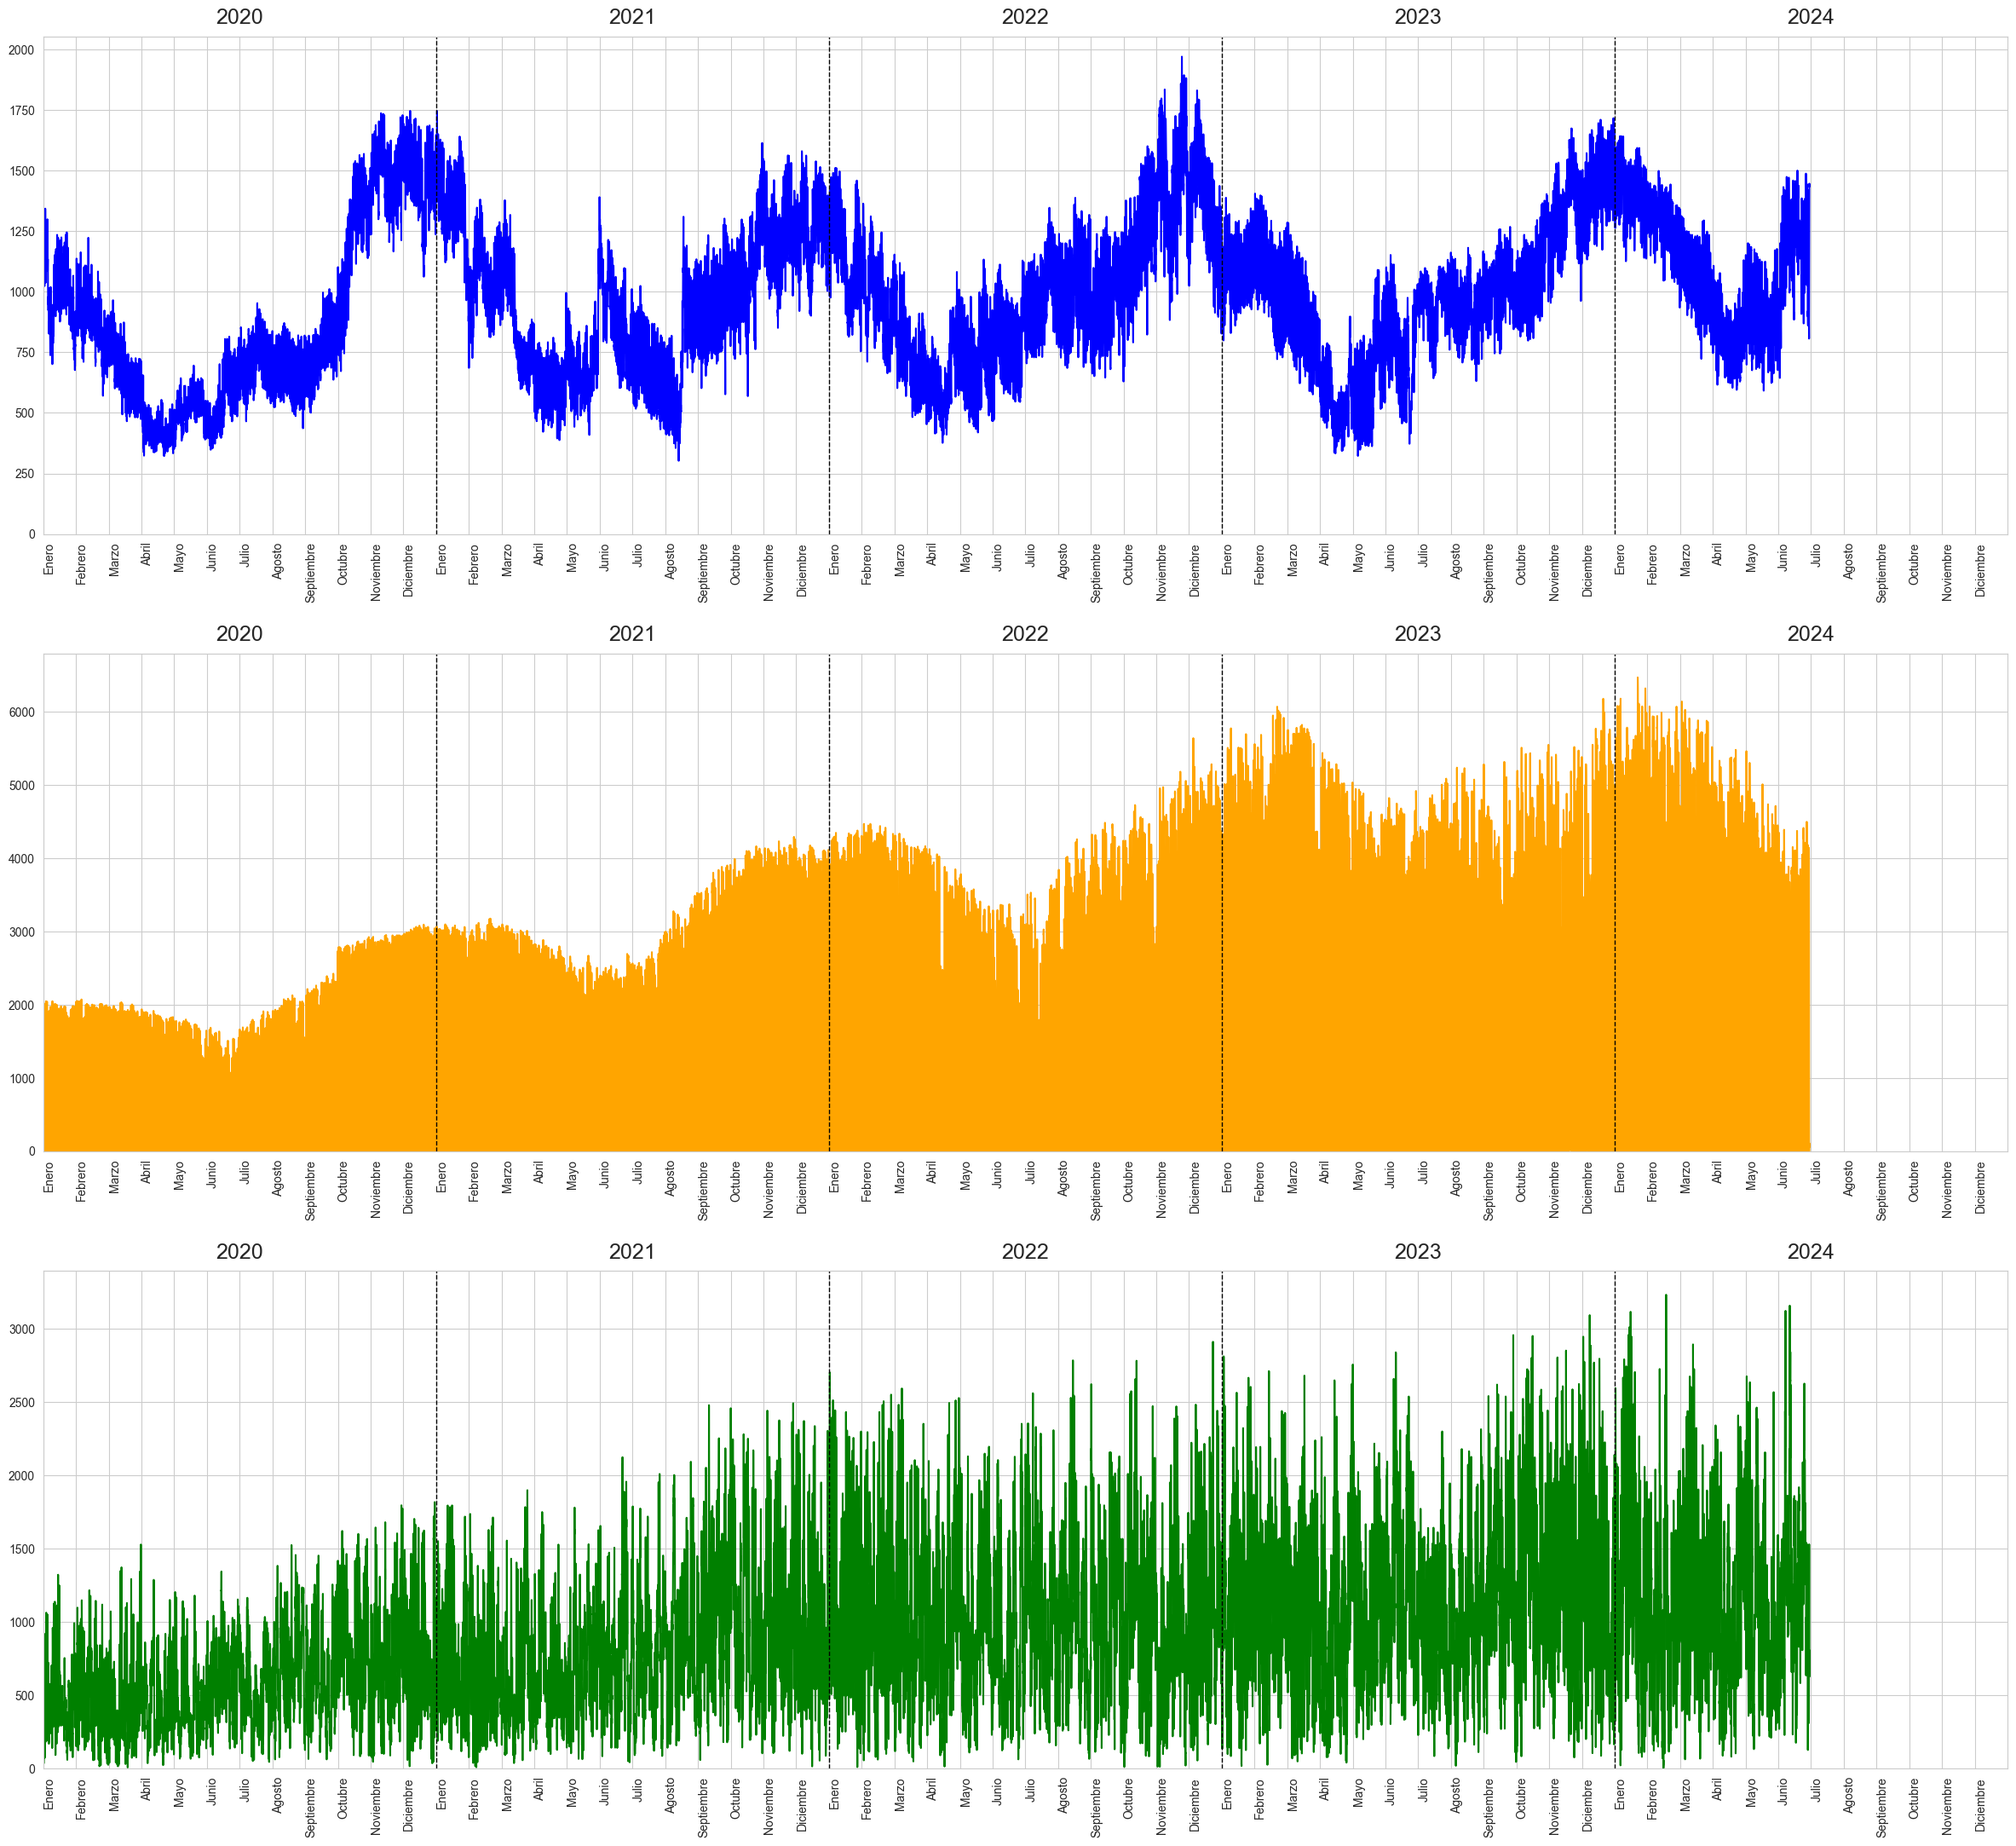

In [9]:
def GraficarSistema(df_Sist,df_CapSist=None,plot_cap=False):

    sns.set_style("whitegrid")

    fig, ax = plt.subplots(3,1, figsize=(24,22))

    # Cambiar el tamaño de la fuente
    plt.rcParams.update({'font.size': 18})
    years = list(df_Sist.reset_index().Year.unique())
    meses = list(df_Sist.reset_index().Month.unique())

    meses = [numbers_months[mes] for mes in meses]

    n_years = len(years)
    n_meses = n_years*12

    x_axis = np.arange(n_meses)
    meses = meses*n_years

    ax[0].plot(df_Sist['Hidro'].values, label='Hidro', color='blue')
    ax[1].plot(df_Sist['Solar'].values, label='Solar', color='orange')
    ax[2].plot(df_Sist['Eolico'].values, label='Eolico', color='green')

    if plot_cap:
        ax[0].plot(df_CapSist['Hidro'].values, color='blue', linestyle='--')
        ax[1].plot(df_CapSist['Solar'].values, color='orange', linestyle='--')
        ax[2].plot(df_CapSist['Eolica'].values, color='green', linestyle='--')

    print(len(ax))
    for idx in range(len(ax)):
        max = ax[idx].get_ylim()[1]
        for i in range(1,n_years):
            ax[idx].vlines(i*8760, 0, max, color='k', linestyle='--', linewidth=1)
        ax[idx].set_ylim(0,max)

        secx = ax[idx].secondary_xaxis('top')
        secx.set_xticks(np.arange(8760/2, 8760*n_years+1, 8760))
        secx.set_xticklabels(years)
        secx.tick_params(top = False)

        ax[idx].set_xlim(0, 8760*n_years)

        ax[idx].set_xticks(np.arange(0, 8760*n_years, 8760/12))
        # displaces the x-axis ticks to the middle of the month
        ax[idx].set_xticklabels(meses, rotation=90, ha='left')

    fig.tight_layout()

GraficarSistema(df_Sist)

In [14]:
# Directorios principales
"""
Cap_dir = os.path.join(Estudios_dir, 'Output')

df_Cap = pd.read_csv(os.path.join(Cap_dir, 'CapacidadInstalada.csv'))

def ExpandCap(df_Sist,df_Cap):
    df_Time = df_Sist.reset_index()[['Year','Month','Day','Hour']]

    for idx, row in df_Time.iterrows():
        Year = row['Year']
        Month = row['Month']
        Day = row['Day']
        Hour = row['Hour']

        try:
            df_Time.loc[idx,'Eolica'] = df_Cap[(df_Cap['Year']==Year) & (df_Cap['Month']==Month)]['Eolica'].values[0]
            df_Time.loc[idx,'Solar'] = df_Cap[(df_Cap['Year']==Year) & (df_Cap['Month']==Month)]['Solar'].values[0]
            df_Time.loc[idx,'Hidro'] = df_Cap[(df_Cap['Year']==Year) & (df_Cap['Month']==Month)]['Hidro'].values[0]
        except:
            #print(f'No se encontró la capacidad instalada para el año {Year} y mes {Month}')
            df_Time.loc[idx,'Eolica'] = 0
            df_Time.loc[idx,'Solar'] = 0
            df_Time.loc[idx,'Hidro'] = 0

    df_Time.set_index(['Year','Month','Day','Hour'],inplace=True)
    return df_Time

df_Cap_ext = ExpandCap(df_Sist,df_Cap)

GraficarSistema(df_Sist,df_Cap_ext,plot_cap=True)
"""

"\nCap_dir = os.path.join(Estudios_dir, 'Output')\n\ndf_Cap = pd.read_csv(os.path.join(Cap_dir, 'CapacidadInstalada.csv'))\n\ndef ExpandCap(df_Sist,df_Cap):\n    df_Time = df_Sist.reset_index()[['Year','Month','Day','Hour']]\n\n    for idx, row in df_Time.iterrows():\n        Year = row['Year']\n        Month = row['Month']\n        Day = row['Day']\n        Hour = row['Hour']\n\n        try:\n            df_Time.loc[idx,'Eolica'] = df_Cap[(df_Cap['Year']==Year) & (df_Cap['Month']==Month)]['Eolica'].values[0]\n            df_Time.loc[idx,'Solar'] = df_Cap[(df_Cap['Year']==Year) & (df_Cap['Month']==Month)]['Solar'].values[0]\n            df_Time.loc[idx,'Hidro'] = df_Cap[(df_Cap['Year']==Year) & (df_Cap['Month']==Month)]['Hidro'].values[0]\n        except:\n            #print(f'No se encontró la capacidad instalada para el año {Year} y mes {Month}')\n            df_Time.loc[idx,'Eolica'] = 0\n            df_Time.loc[idx,'Solar'] = 0\n            df_Time.loc[idx,'Hidro'] = 0\n\n    df_Ti